# Lagrangian box model

Here we're going to build a simple box model for a Lagrangian particle. We'll use the model to explore the effects of different processes on the particle's evolution. We'll start with a simple model, and then add complexity as we go.

Here we have particles moving in cube, and when they collide they coagulate. (no condesation, evaporation or forces like drag)

These particles do not have realistic properties, now but we'll add those later.

The core of the function calls are from the `particula.lagrangian` module. This model is pytorch focused, so we can switch between CPU and GPU.
This is important when we start to add complexity and increase the number of particles, then we'll need to use the GPU.

In [8]:
# %% imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from particula.lagrangian import lag_util

t_gen = torch.Generator()
t_type = torch.float32

## Define the Box

This first step is to define the system. Which is a combination of fixed parameters and randomly generated initial conditions.

In [9]:
TOTAL_NUMBER_OF_PARTICLES = 200
TIME_STEP = 0.01
SIMULATION_TIME = 100
MASS = 3
CUBE_SIDE = 50
speed = 10
save_points = 50


position = torch.rand(3, TOTAL_NUMBER_OF_PARTICLES, dtype=t_type) \
    * CUBE_SIDE - CUBE_SIDE/2
velocity = torch.rand(3, TOTAL_NUMBER_OF_PARTICLES, dtype=t_type) \
    * speed - speed/2
force = torch.zeros(3, TOTAL_NUMBER_OF_PARTICLES, dtype=t_type)

mass = torch.ones(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type) * MASS
density = torch.ones(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type) * 1
indices = torch.arange(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type)  # could be int

total_iterations = int(SIMULATION_TIME / TIME_STEP)
total_mass = torch.zeros(total_iterations, dtype=t_type)

gravity = torch.tensor(
    [0, -9.81, 0]).repeat(TOTAL_NUMBER_OF_PARTICLES, 1).transpose(0, 1)

## Allocate Saving Variables

We'll save the `position` and `mass`, of the particles at a fixed number of save points.

In [10]:
save_position = np.zeros((3, TOTAL_NUMBER_OF_PARTICLES, save_points))
save_mass = np.zeros((TOTAL_NUMBER_OF_PARTICLES, save_points))

# calculate save iterations
save_iterations = np.linspace(0, total_iterations, save_points, dtype=int)

## Run the Box Model

Now we run the model. The steps are:

1. Check for particles outside the box
2. Calculate pairwise distances to center of the particle
3. Calculate pairwise distances to surface of the particle
4. Find collisions
5. Coallesce particles that collided
6. Force calculations actin on the particles
7. Integrate the equations of motion, update the position and velocity
8. Save the data

In [11]:
save_counter = 0

for i in tqdm(range(total_iterations), desc='Simulation'):

    # CUBE boundary condition, wrap around
    position = lag_util.boundary_wrapped_sphere(position, CUBE_SIDE)
    # Calculate pairwise distance
    distance_matrix = lag_util.calculate_pairwise_distance(position)
    # Calculate surface to surface distance of the spheres
    # self radius
    distance_matrix -= lag_util.radius(mass, density).unsqueeze(1)
    # other radius
    distance_matrix -= lag_util.radius(mass, density).unsqueeze(0)

    # Find collisions
    valid_collision_indices_pairs = lag_util.find_collisions(
        distance_matrix=distance_matrix,
        indices=indices,
        mass=mass)

    velocity, mass = lag_util.coalescence(
        velocity=velocity,
        mass=mass,
        collision_indices_pairs=valid_collision_indices_pairs)

    # calculate force for gravity
    force = mass * gravity

    # Integrate
    position, velocity = lag_util.integration_leapfrog(
        position=position,
        velocity=velocity,
        force=force,
        mass=mass,
        time_step=TIME_STEP)

    # save position
    if i == save_iterations[save_counter]:
        save_position[:, :, save_counter] = position.detach().numpy()
        save_mass[:, save_counter] = mass.detach().numpy()
        save_counter += 1

Simulation: 100%|██████████| 10000/10000 [01:08<00:00, 146.05it/s]


## Plot the Final 3D Position

We'll exclude the particle indices that have zero mass, as these have coalesced with other particles.

Number of particles at the end: 22


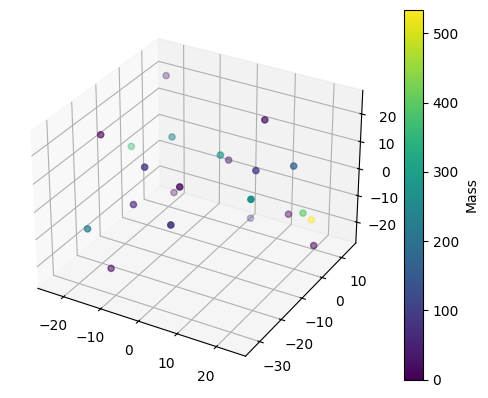

In [12]:
position_final = save_position[:, :, -2]
mass_final = save_mass[:, -2]
filter_zero_mass = mass_final > 0
print(f"Number of particles at the end: {filter_zero_mass.sum()}")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Define color map range
cmap = plt.cm.viridis  # You can choose any other colormap
# Plot final positions
scatter2 = ax.scatter(
    position_final[0, filter_zero_mass],
    position_final[1, filter_zero_mass],
    position_final[2, filter_zero_mass],
    c=mass[filter_zero_mass],
    cmap=cmap,)

# Create color bar
cbar = plt.colorbar(scatter2, ax=ax)
cbar.set_label('Mass')
plt.show()
fig.tight_layout()

## Plot the Final Mass Distribution

We'll normalize by the initial `MASS`, so we can see the mass distribution change and multiples.


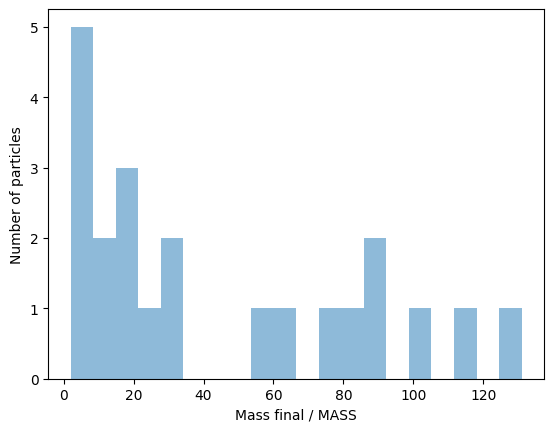

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(mass_final[filter_zero_mass]/MASS, bins=20, alpha=0.5)
ax.set_xlabel('Mass final / MASS')
ax.set_ylabel('Number of particles')
plt.show()
fig.tight_layout()